The aim of this notebook is to test the LM distance minimization procedure on real image.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)

## Segmentation


In [35]:
brigthfield_path = '../../../assets/sample_image_actin_surligned.tif'
#dapi_path = '../assets/CELLPROFILER_sample_image_dapi.tiff.csv'
dapi_path = '../../../assets/sample_image_dapi.tiff'
scp_path = '../../../assets/star_convex_polynoms/models'
#initialising the mesh
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path,
                                                           threshold=2,
                                                           method='SCP',
                                                           scp_model_path=scp_path,
                                                           rol_window_inside=20,
                                                           rol_window_outside=5)
Nf = organo.Nf
geom.update_all(organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + np.sin(np.pi/Nf)/(np.mean(organo.face_df.area)*organo.settings['R_in']*np.sin(2*np.pi/Nf)-2*np.mean(organo.face_df.area)*
                             np.sin(2*np.pi/Nf)*(8-2*(np.sin(2*np.pi/Nf)**2-4)/(np.sin(np.pi/Nf)**4+8*np.sin(np.pi/Nf)**2)
                                                )*(organo.settings['R_in']+organo.settings['R_out']))
print(alpha)
alpha = 1.001
# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)
normalize_scale(organo, geom)
geom.update_all(organo)
inners = inners[:int(2830/2)]
outers = outers[:int(outers.shape[0]/2)]

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01


Loading network weights from 'weights_best.h5'.


Reseting datasets values with new specs


{'geometry': 'planar', 'R_in': 119.94799383544922, 'R_out': 134.21666275024415, 'R_vit': None}
0.9999999950313019


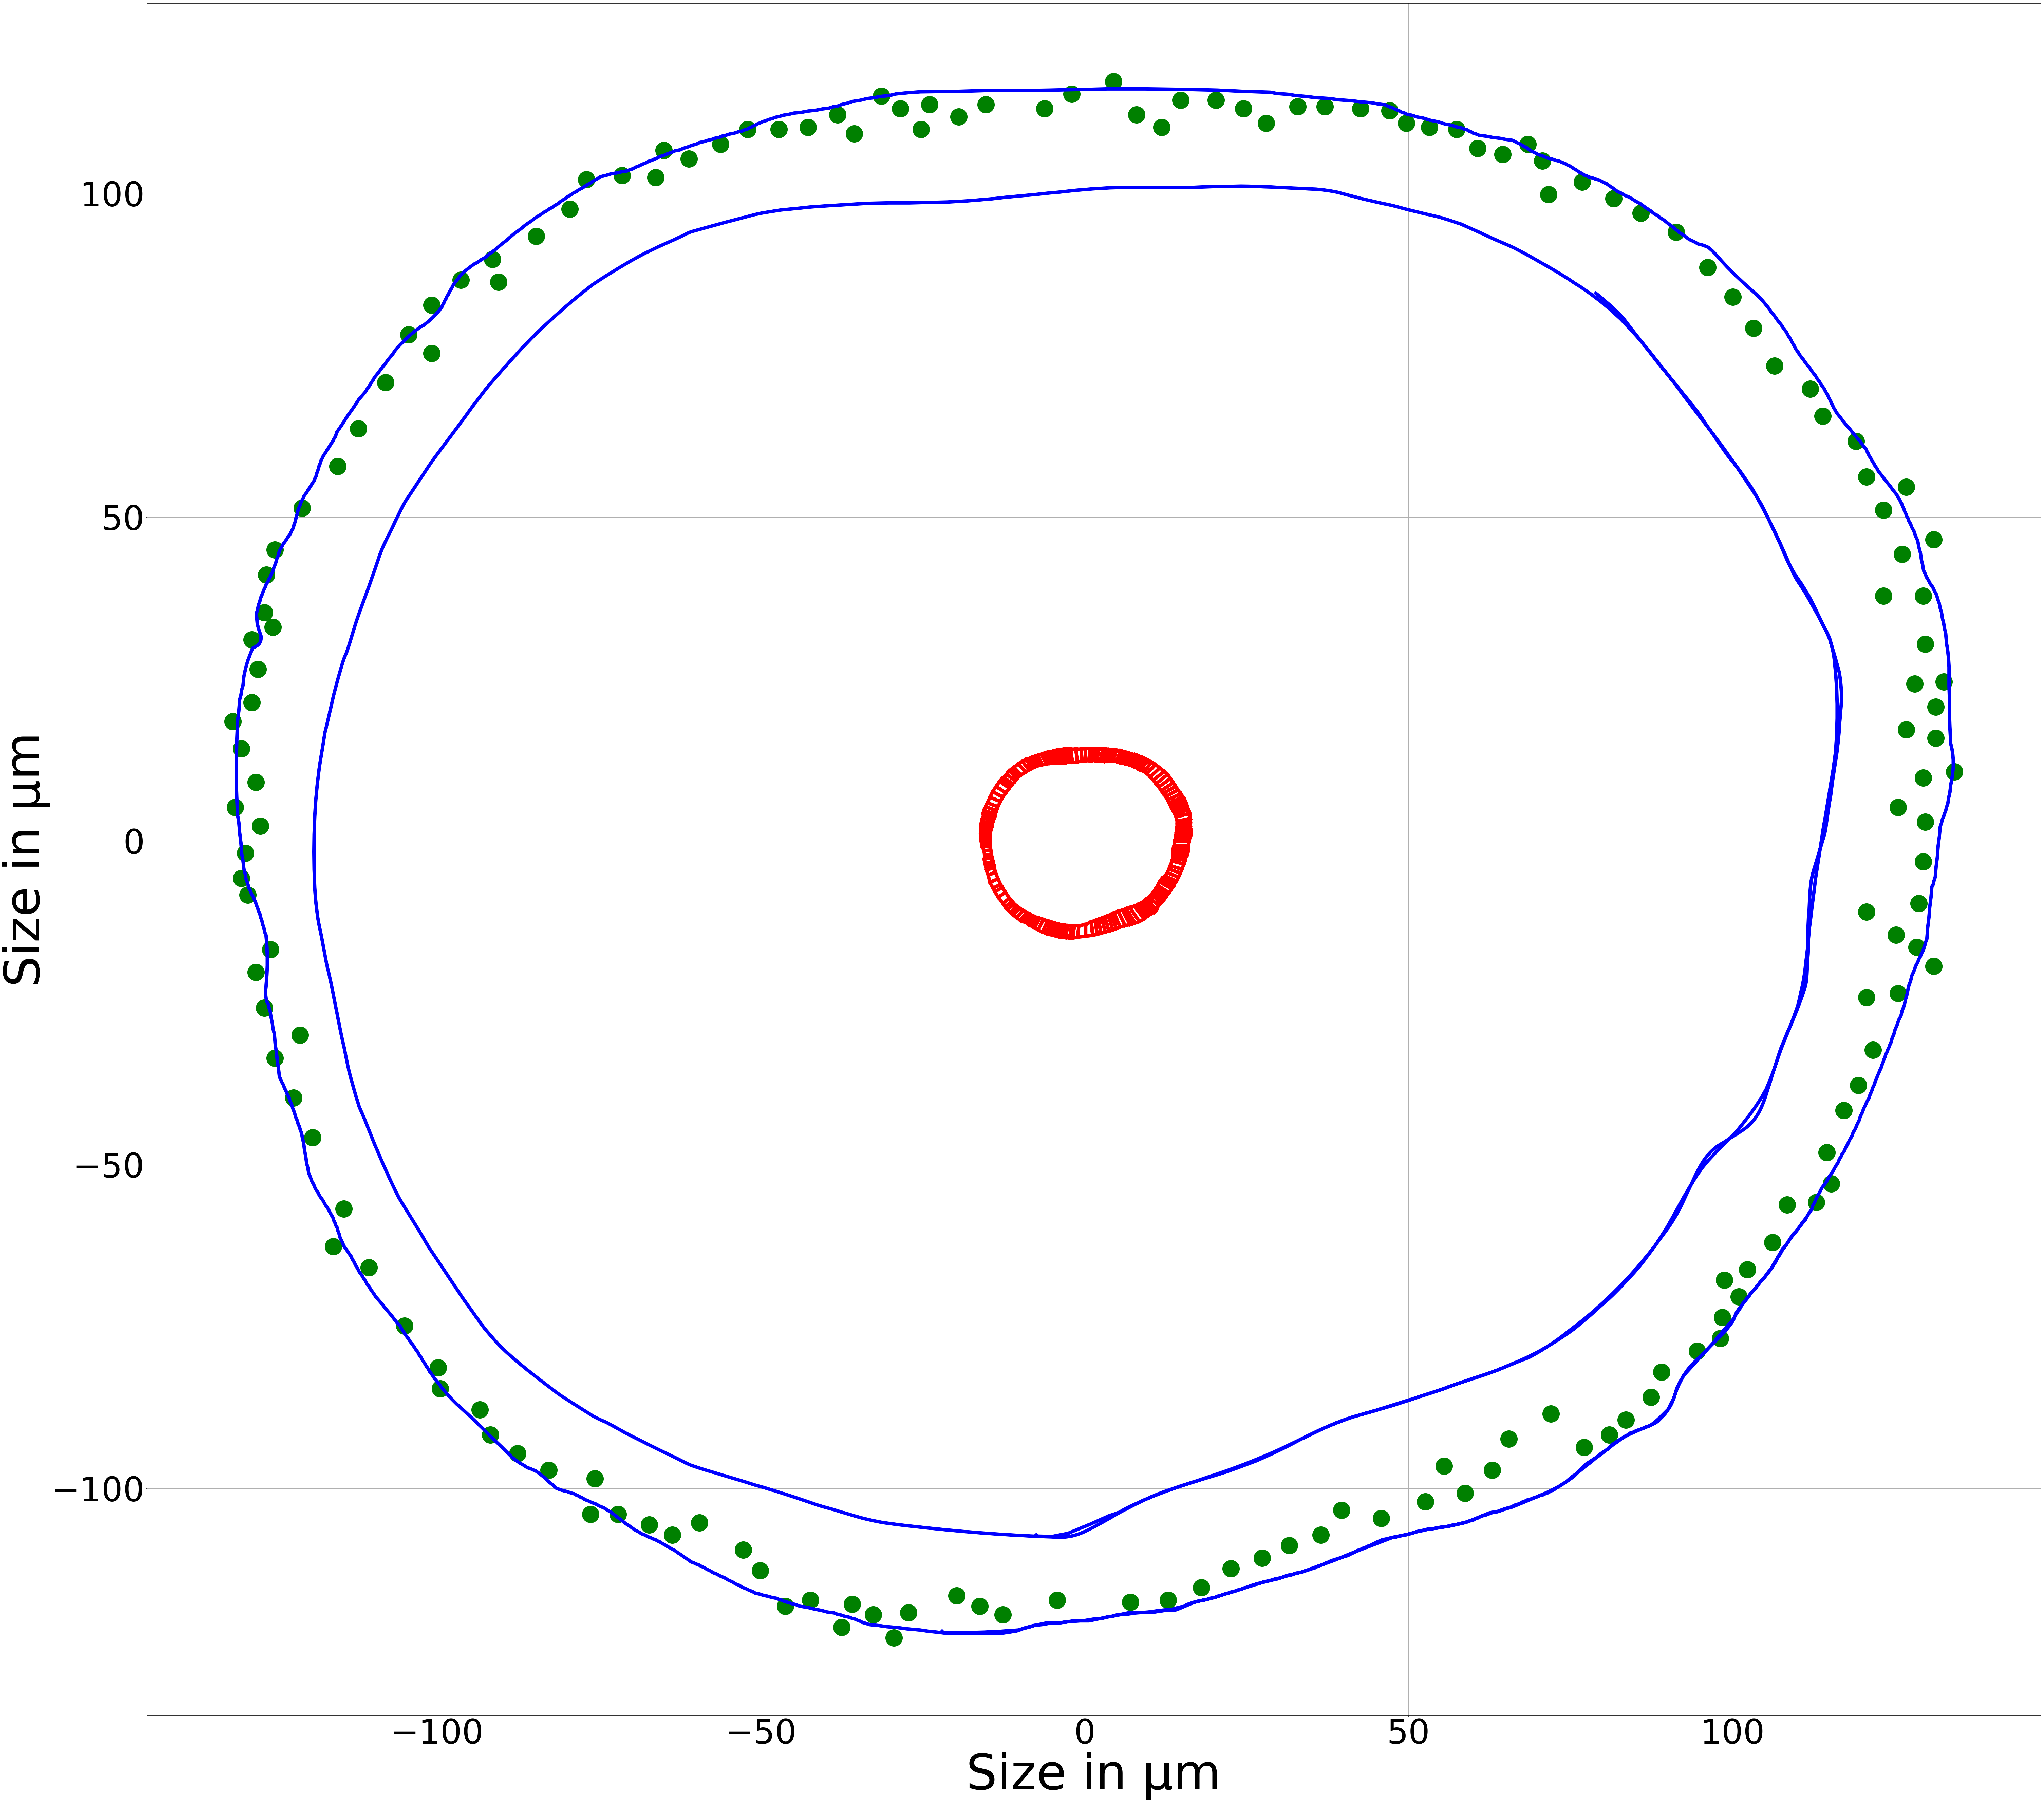

In [36]:
fig, ax = plt.subplots()
plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
quick_edge_draw(organo, c='r', ax=ax, linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

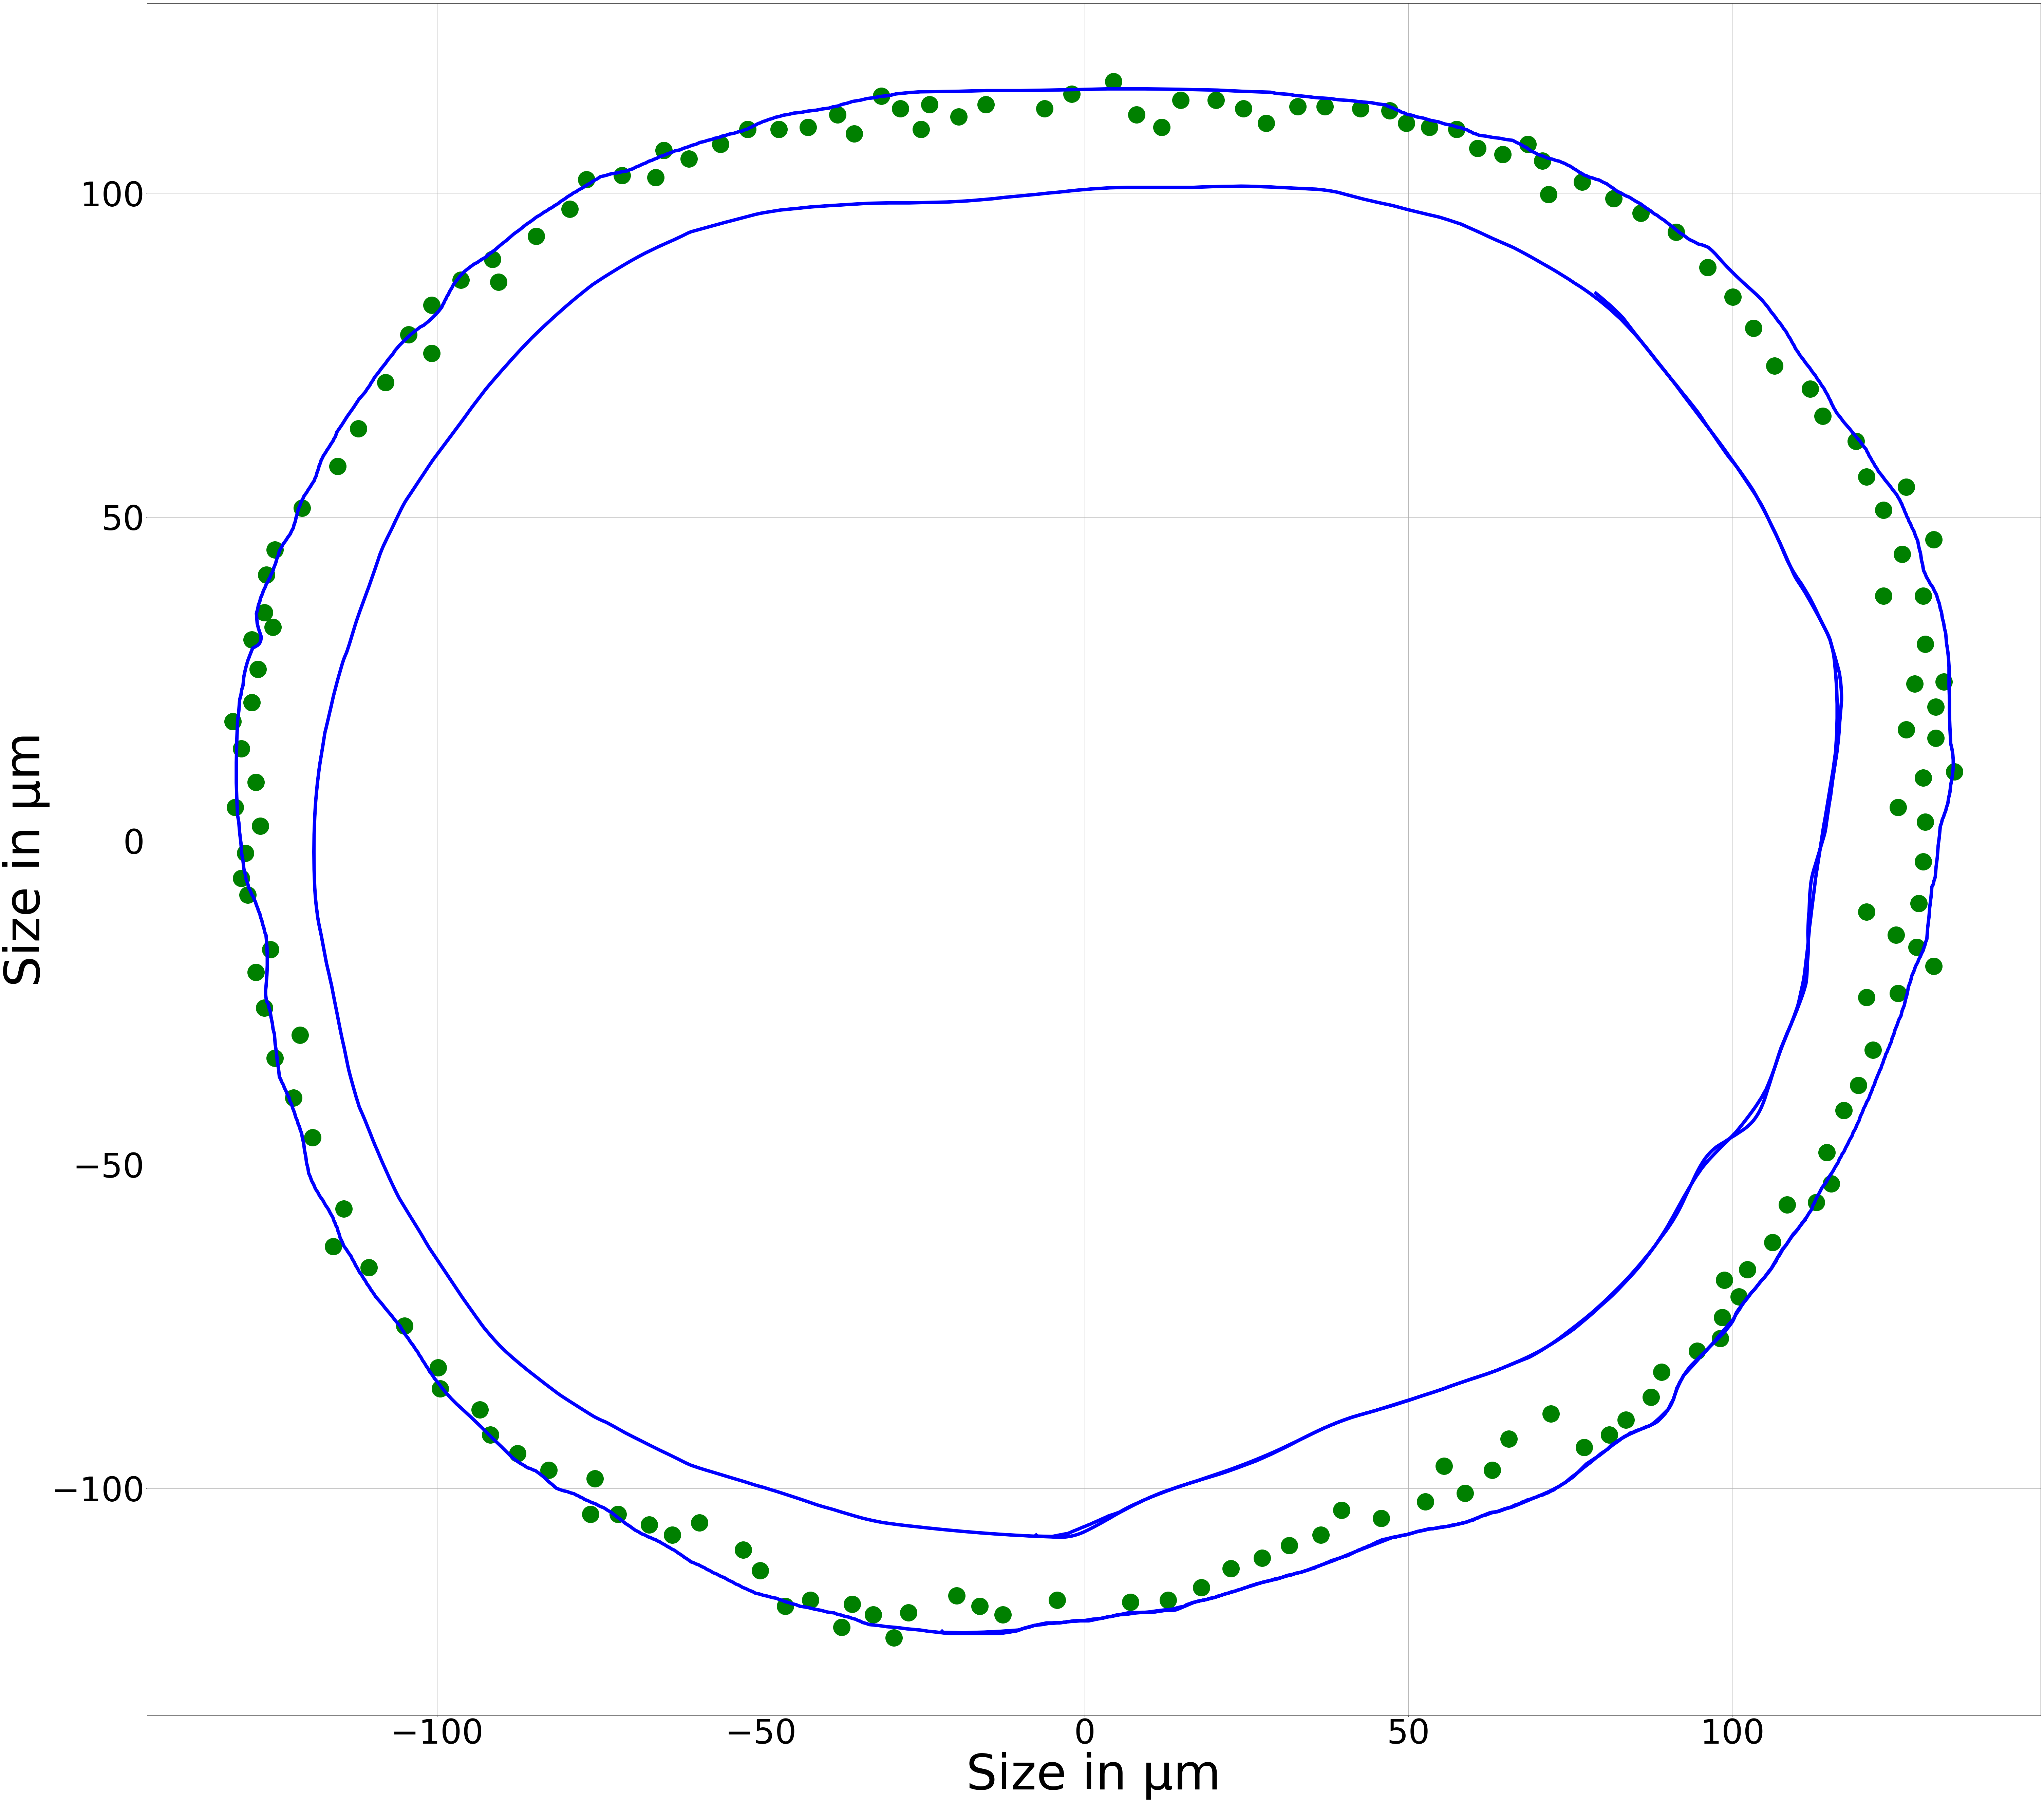

In [37]:
fig, ax = plt.subplots()
plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

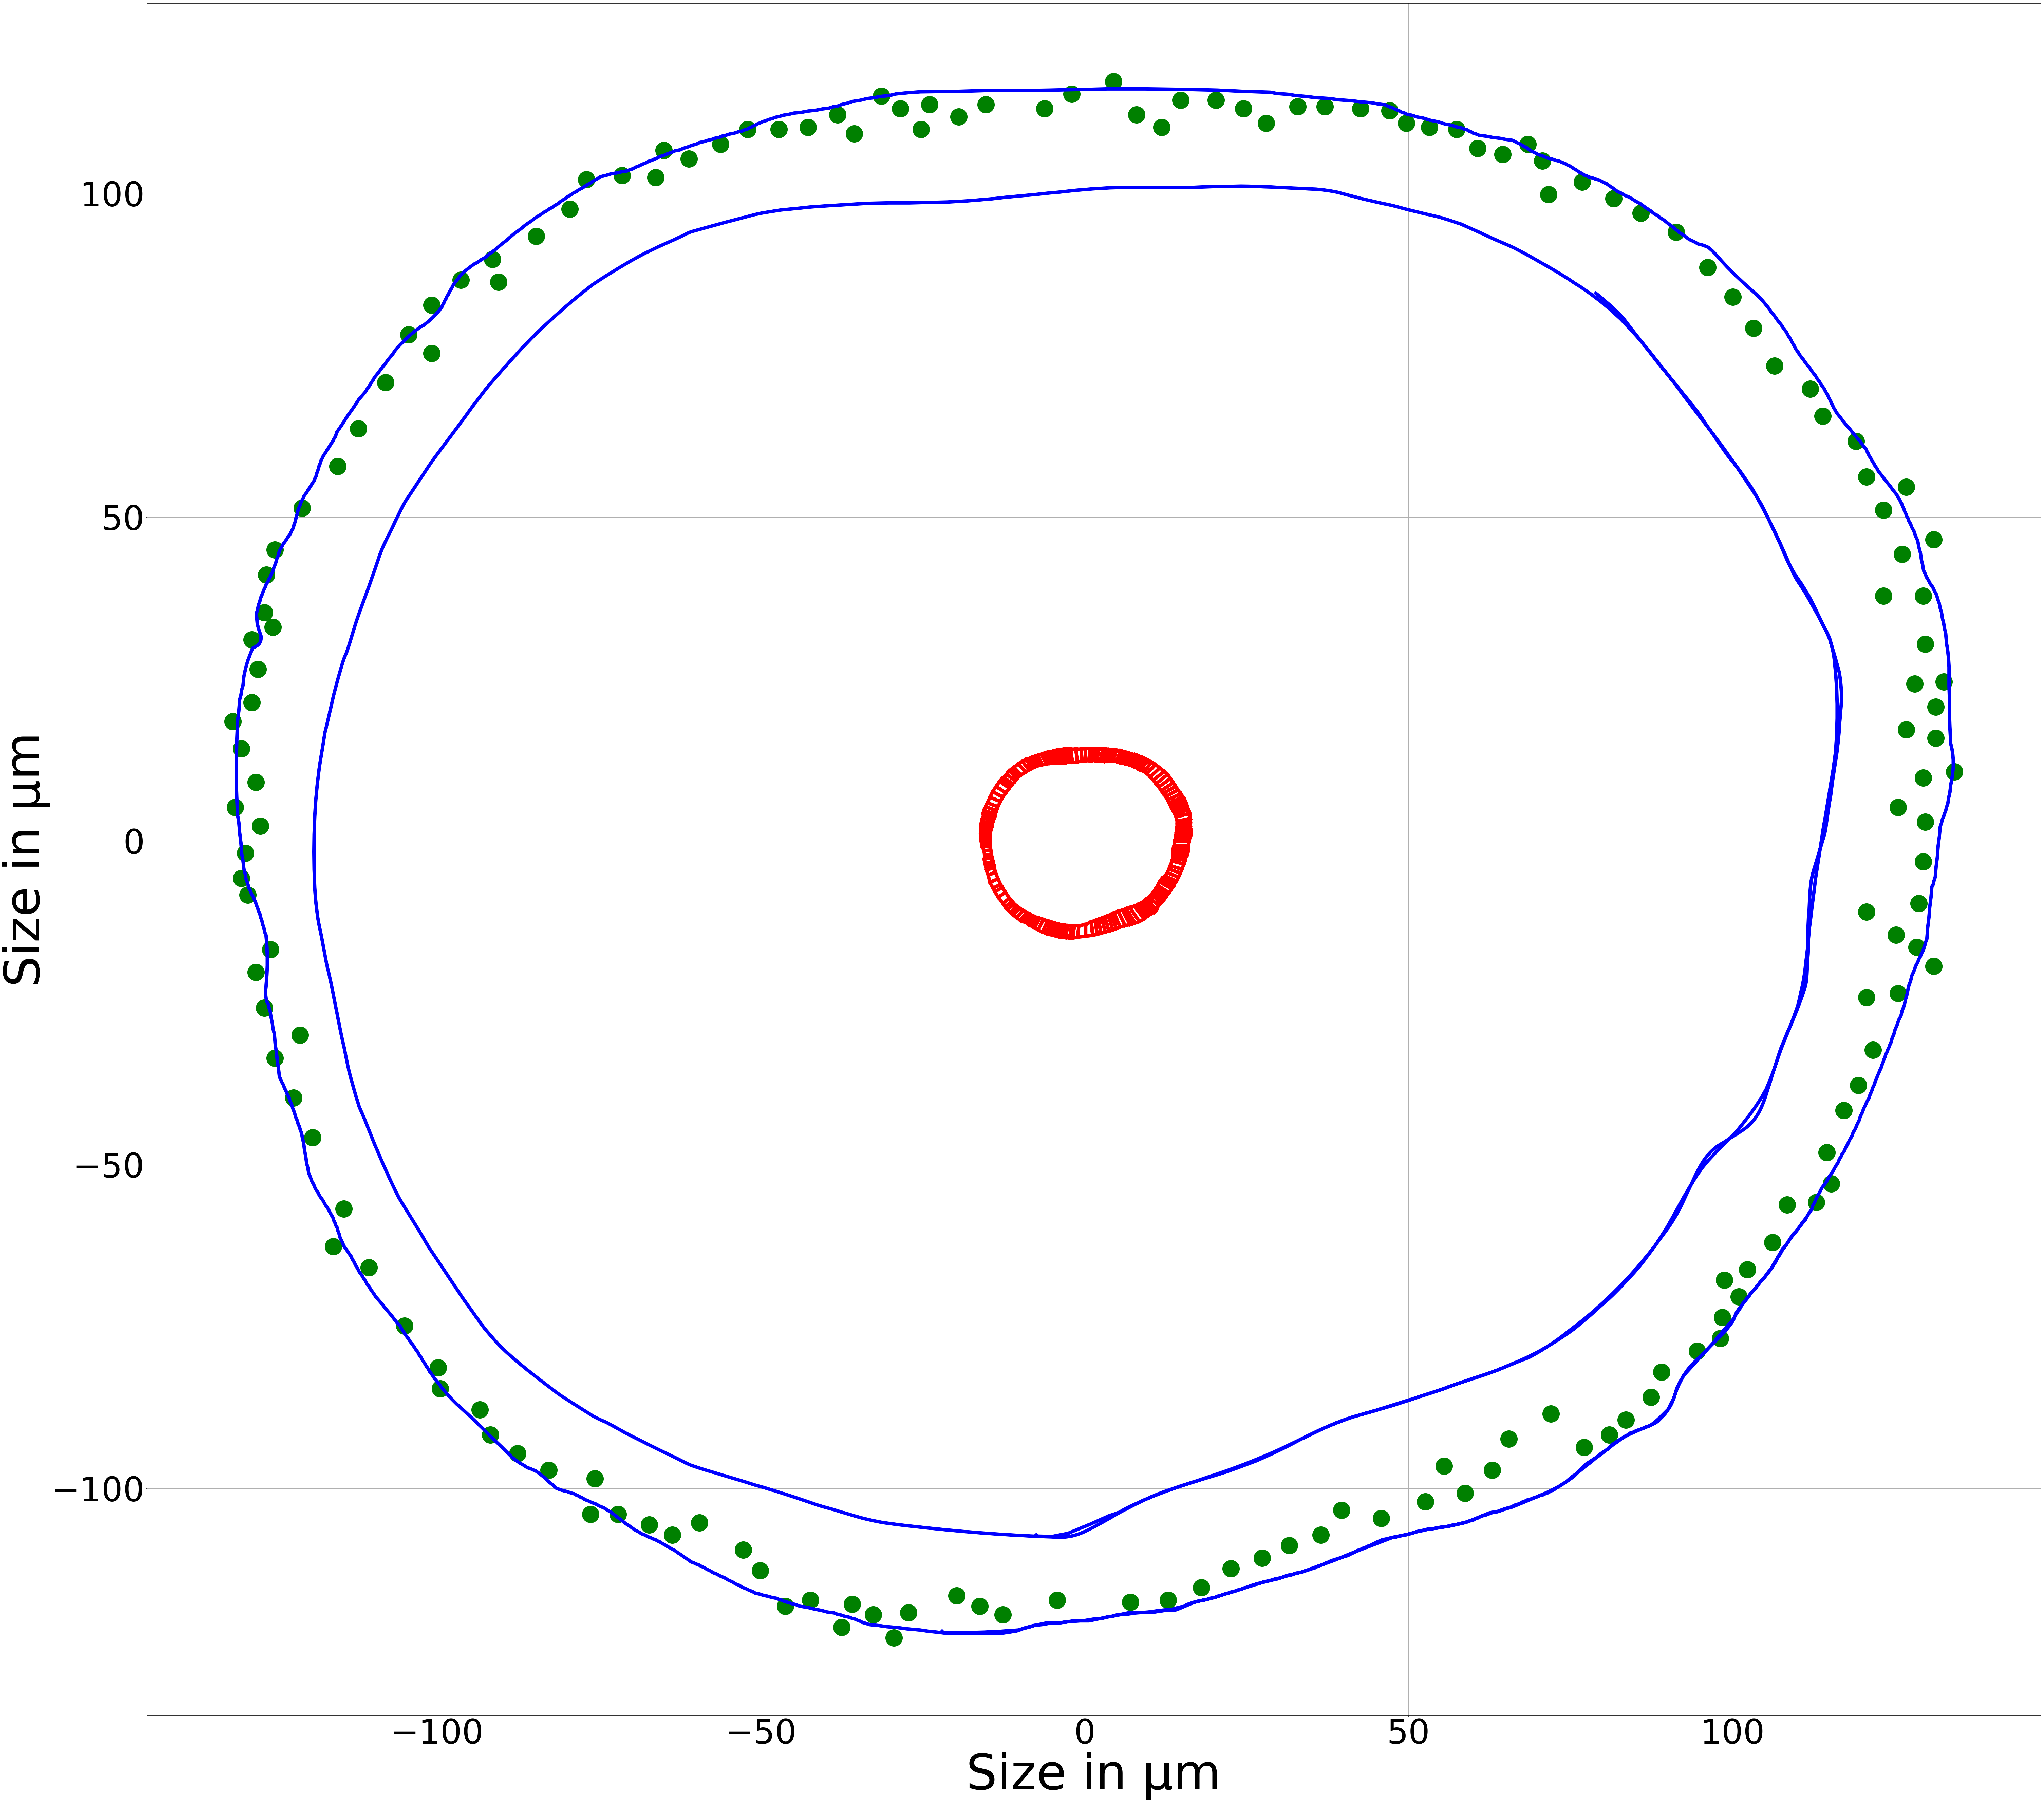

In [38]:
fig, ax = plt.subplots()

plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
quick_edge_draw(organo, c='r', ax=ax, linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

Creating a printing function

In [39]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')

Define the optimization parameters

In [40]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-8,'ftol': 1e-5, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-7,'ftol': 1e-6, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', 'output_path': './PSQP_min_dist'}

reg_weight = 1e-3
theta = 0.02

## Force inference

In [41]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=0.1):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

In [42]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)

In [43]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(organo.Nf,
                                                  organo.settings['R_in'],
                                                  organo.settings['R_out']))

In [44]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (organo.settings['R_out']-organo.settings['R_in'])*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    #((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2)))
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    #api_vert = organo.vert_df.loc[organo.apical_verts[[cell, (cell+1)%organo.Nf]],
    #                              ('x', 'y')].values
    polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.95693172, 0.94232203, 0.94547194, 0.95858202, 0.96833792,
       0.9648219 , 0.91607392, 0.85245031, 0.80282889, 0.77572843,
       0.74689122, 0.73455372, 0.76503627, 0.77568011, 0.74695913,
       0.7138449 , 0.7060971 , 0.68668743, 0.667607  , 0.77223273,
       0.71364921, 0.66963075, 0.71233387, 0.75011691, 0.637165  ,
       0.63926996, 0.63303069, 0.64547174, 0.59256778, 0.5841828 ,
       0.616935  , 0.63340362, 0.65084187, 0.67714867, 0.71492676,
       0.75004673, 0.79005016, 0.8337358 , 0.85660728, 0.87035794,
       0.87652863, 0.90518726, 0.93586089, 0.91716886, 0.87918212,
       0.8638491 , 0.88470231, 0.91139483, 0.91125517, 0.90822272,
       0.86054048, 0.84655011, 0.85550326, 0.84336572, 0.82600268,
       0.83246584, 0.84701109, 0.84902142, 0.81567255, 0.79344111,
       0.79803644, 0.82439882, 0.86254302, 0.89941738, 0.94820363,
       1.0266123 , 1.04023913, 1.08902115, 1.1329334 , 1.09416166,
       1.09408824, 1.10747654, 1.11939874, 1.0692942 , 0.95281

[0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.17886872924232694, 0.1788687292

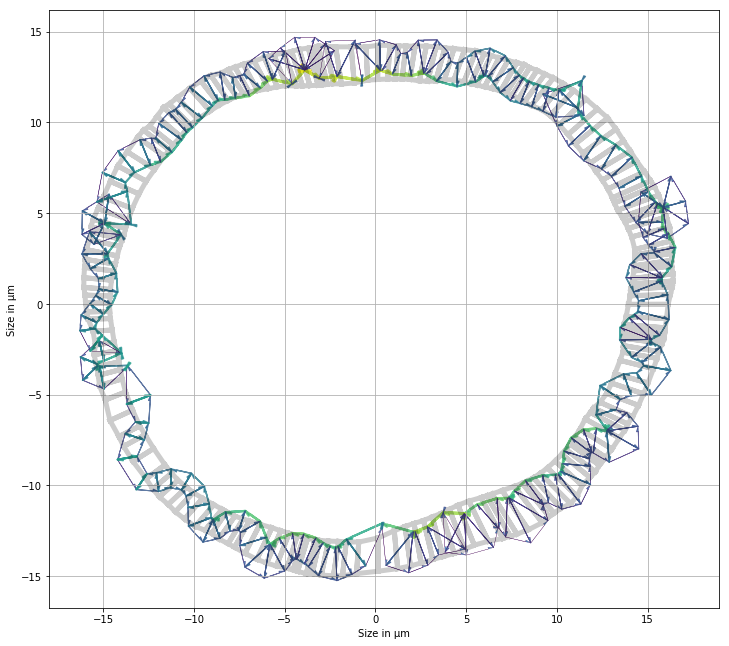

In [47]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
matrix = matrix[:-1]
constant = constant[:-1]
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
#avg_cste = [2.44/(3*organo.Nf)*4]*organo.Nf
print(avg_cste)
#avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
#area_ela_line = np.concatenate((np.zeros(organo.Nf*3),
#                                np.ones(organo.Nf),
#                                [0]))
#matrix = np.vstack((matrix, area_ela_line))
#constant = np.concatenate((constant, [-params_in_sym_mesh[0]*organo.Nf]))
print(params_in_sym_mesh[0]*organo.Nf)
print(avg_cste)
for i in range(organo.Nf):
    i_cell_line = np.zeros(4*organo.Nf+1)
    index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
    index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
    index[-1] = index_suiv[-2]
    #index[-1] = 40
    #print(index)
    i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
    #print(i_cell_line)
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
print(matrix.shape, constant.shape)
mat_eq_cst, residuals = nnls(matrix, constant)
organo_eq_cst = organo.copy()
organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                 mat_eq_cst[:3*organo.Nf])
organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area + mat_eq_cst[3*organo.Nf:
                                                                                          4*organo.Nf]
organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo_eq_cst, geom, model)
print_tensions(organo_eq_cst, organo)
print(mat_eq_cst[organo.apical_edges])
print('Apical tensions: ', mat_eq_cst[organo.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo.lateral_edges[:organo.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo), axis=1)),
      '\nNNLS residuals: ', residuals)

## Starting the optimization procedure

Sixth try : initial point obtained with NNLS computing only tensions, with the star convex polygons nuclei detection and moving average window equal to 100.

In [53]:
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
start_copy = time.time()
iprint_file = "../../../assets/dist_at_each_f_ev/20_03_real_img.txt"
to_opt_organo = organo.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas_copy = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    COPY_OR_SYM='copy',                                    
                                    **lm_opt)
end_copy = time.time()
print('Execution time: ', start_copy - end_copy)

275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
282.7029851771289 [0.08069675 0.33321159 0.7057526  ... 0.         0.         0.        ]
276.47284035697373 [0.08874599 0.32077265 0.68498649 ... 0.         0.         0.        ]
279.4620976859868 [0.08916261 0.31305245 0.68331779 ... 0.         0.         0.        ]
236.69740935143173 [0.2109016  0.22786751 0.39330258 ... 0.         0.         0.        ]
281.1203629069906 [0.08599713 0.32866525 0.6992825  ... 0.         0.         0.        ]
276.920929345191 [0.08612567 0.31070687 0.65245162 ... 0.         0.         0.        ]
277.5083793026738 [0.08688235 0.31252609 0.67061281 ... 0.         0.         0.        ]
277.8182619627562 [0.0893168  0.31549822 0.67012321 ... 0.         0.         0.        ]
281.43

275.16767492664593 [0.0977547  0.31595649 0.65411716 ... 0.         0.         0.        ]
275.6291293219481 [0.1052316  0.30811611 0.6250016  ... 0.         0.         0.        ]
281.7804688601935 [0.09064051 0.32105415 0.65959898 ... 0.         0.         0.        ]
280.40634001436365 [0.08020126 0.3276604  0.69234176 ... 0.         0.         0.        ]
277.6903588050742 [0.08504127 0.31230129 0.6608398  ... 0.         0.         0.        ]
277.5134912677155 [0.08610161 0.31725073 0.67981229 ... 0.         0.         0.        ]
280.39554807015827 [0.07704939 0.32367011 0.67331523 ... 0.         0.         0.        ]
277.6348032070631 [0.08050899 0.31749373 0.68130742 ... 0.         0.         0.        ]
242.94892453543207 [0.2243789  0.24010607 0.42050143 ... 0.         0.         0.        ]
276.2959696330407 [0.08628463 0.31306432 0.66648466 ... 0.         0.         0.        ]
272.8749963969833 [0.16944709 0.27832733 0.60965427 ... 0.         0.         0.        ]
273.23

272.49194716793704 [0.17754742 0.2827023  0.59992745 ... 0.         0.         0.        ]
244.8921016244945 [0.22866417 0.24431561 0.42341367 ... 0.         0.         0.        ]
278.85100206085866 [0.08368612 0.32405682 0.69375257 ... 0.         0.         0.        ]
276.0699613015372 [0.0932859  0.30512465 0.6345614  ... 0.         0.         0.        ]
278.7057915292595 [0.08697024 0.31976104 0.67642207 ... 0.         0.         0.        ]
275.91071102489934 [0.08438037 0.31520437 0.67132024 ... 0.         0.         0.        ]
277.779278098596 [0.09261049 0.31358278 0.64794529 ... 0.         0.         0.        ]
265.3052582041796 [0.21497942 0.2800712  0.54862533 ... 0.         0.         0.        ]
275.5286714054505 [0.0863184  0.31319692 0.65590105 ... 0.         0.         0.        ]
279.7251295489133 [0.07974919 0.32300093 0.68533887 ... 0.         0.         0.        ]
278.9930324757163 [0.08050286 0.31503478 0.66895169 ... 0.         0.         0.        ]
278.2460

278.39595178606464 [0.07715074 0.31943476 0.68279834 ... 0.         0.         0.        ]
275.1458623647891 [0.09503508 0.30510792 0.64760323 ... 0.         0.         0.        ]
275.2904487032089 [0.18045861 0.28977886 0.6038354  ... 0.         0.         0.        ]
279.35399359594015 [0.08186144 0.32943541 0.69723612 ... 0.         0.         0.        ]
278.8966630659737 [0.08526552 0.32721203 0.70312113 ... 0.         0.         0.        ]
277.57873357116677 [0.08297073 0.32213634 0.68800607 ... 0.         0.         0.        ]
279.3100458655116 [0.08530562 0.33242501 0.7023563  ... 0.         0.         0.        ]
272.75380782227694 [0.09536316 0.30405482 0.65178597 ... 0.         0.         0.        ]
281.36259398966365 [0.08340177 0.32974086 0.69233229 ... 0.         0.         0.        ]
272.4345926628049 [0.1176022  0.30223129 0.60755452 ... 0.         0.         0.        ]
275.35916557825993 [0.09550759 0.30672788 0.66493042 ... 0.         0.         0.        ]
277.

276.34478188293656 [0.0821756  0.31817816 0.6766092  ... 0.         0.         0.        ]
272.04208674348575 [0.17262637 0.28284812 0.59670243 ... 0.         0.         0.        ]
281.3305384185388 [0.08510093 0.32039684 0.65837486 ... 0.         0.         0.        ]
281.4538472843839 [0.07419566 0.32946687 0.70687422 ... 0.         0.         0.        ]
280.0610747626873 [0.08014548 0.32123576 0.66445883 ... 0.         0.         0.        ]
277.90471350388214 [0.0834295  0.31383461 0.65762747 ... 0.         0.         0.        ]
273.1324492649103 [0.16762632 0.28265855 0.60969627 ... 0.         0.         0.        ]
277.0247273164015 [0.10054405 0.31284495 0.635358   ... 0.         0.         0.        ]
277.6088903961829 [0.16647931 0.29186488 0.62415057 ... 0.         0.         0.        ]
280.6339556074811 [0.07242889 0.32670675 0.69243701 ... 0.         0.         0.        ]
277.9327208463546 [0.08503767 0.31434256 0.65298899 ... 0.         0.         0.        ]
279.016

277.58041966380415 [0.08204817 0.32013124 0.68396086 ... 0.         0.         0.        ]
278.4787292484349 [0.08689458 0.32204994 0.64926558 ... 0.         0.         0.        ]
277.30053081364986 [0.08897196 0.32040016 0.66649394 ... 0.         0.         0.        ]
277.42787605944 [0.0838396  0.32089265 0.67985976 ... 0.         0.         0.        ]
278.0191448757618 [0.08456514 0.32636404 0.69175813 ... 0.         0.         0.        ]
274.3562967364352 [0.17081985 0.28759919 0.6058338  ... 0.         0.         0.        ]
275.51976625172824 [0.08519173 0.31894079 0.67950854 ... 0.         0.         0.        ]
271.5963446738729 [0.16935827 0.28027209 0.59647607 ... 0.         0.         0.        ]
271.5288419300151 [0.11905115 0.29473868 0.62378277 ... 0.         0.         0.        ]
275.2215825061606 [0.09150796 0.3084938  0.6677327  ... 0.         0.         0.        ]
275.7878758715216 [0.09583235 0.3092147  0.64340225 ... 0.         0.         0.        ]
277.35722

275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]

275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]

278.5689942008026 [0.084746   0.31639433 0.66006055 ... 0.         0.         0.        ]
278.91829206964934 [0.08803712 0.33284926 0.70382185 ... 0.         0.         0.        ]
275.2543000026163 [0.10353131 0.33886569 0.65333337 ... 0.         0.         0.        ]
265.1973509639327 [0.20537981 0.27890792 0.55712527 ... 0.         0.         0.        ]
277.82179750956016 [0.0939194  0.33500169 0.69686048 ... 0.         0.         0.        ]
276.25844727752917 [0.09457412 0.31365288 0.65830861 ... 0.         0.         0.        ]
274.77634421715595 [0.09466439 0.3221044  0.68192026 ... 0.         0.         0.        ]
282.1337266500142 [0.09737953 0.3334981  0.69780511 ... 0.         0.         0.        ]
278.4877489305594 [0.12161903 0.31712318 0.64210544 ... 0.         0.         0.        ]
275.0483504253299 [0.18068246 0.28415748 0.60055998 ... 0.         0.         0.        ]
277.5592851001145 [0.08466643 0.32652811 0.68860215 ... 0.         0.         0.        ]
281.97

278.4942952596411 [0.0840474  0.32883721 0.68759032 ... 0.         0.         0.        ]
276.1522874459766 [0.10010172 0.32005403 0.67414276 ... 0.         0.         0.        ]
277.2992980987208 [0.0981786  0.32461466 0.62574305 ... 0.         0.         0.        ]
280.84291427452297 [0.08408734 0.3369264  0.7010793  ... 0.         0.         0.        ]
280.91291513411863 [0.08328984 0.33100862 0.70595512 ... 0.         0.         0.        ]
274.2195542142896 [0.13490191 0.30148664 0.62184932 ... 0.         0.         0.        ]
278.0207065639165 [0.0993606  0.33298415 0.6802945  ... 0.         0.         0.        ]
278.86703612315324 [0.09136287 0.33418937 0.68279047 ... 0.         0.         0.        ]
278.3772628305162 [0.11278835 0.31887458 0.64576081 ... 0.         0.         0.        ]
278.81786880217453 [0.0951811  0.33564571 0.70145284 ... 0.         0.         0.        ]
274.9395865531612 [0.11095554 0.31717161 0.63316389 ... 0.         0.         0.        ]
275.82

280.6384715862769 [0.09350573 0.32821549 0.67342001 ... 0.         0.         0.        ]
277.81864204469366 [0.08826882 0.33813172 0.69261092 ... 0.         0.         0.        ]
274.75481332091107 [0.09575345 0.30967694 0.64208281 ... 0.         0.         0.        ]
279.15148925972284 [0.08991519 0.33629448 0.68920581 ... 0.         0.         0.        ]
274.2499448079403 [0.17568732 0.2923487  0.60662439 ... 0.         0.         0.        ]
275.8593063396975 [0.10061939 0.3184081  0.65996603 ... 0.         0.         0.        ]
277.0437524205422 [0.09962733 0.32537647 0.65435914 ... 0.         0.         0.        ]
282.16746166824623 [0.08603818 0.34087304 0.71147393 ... 0.         0.         0.        ]
273.7568012853378 [0.16148147 0.30315341 0.6170493  ... 0.         0.         0.        ]
281.4255573419409 [0.09778296 0.35182434 0.72764386 ... 0.         0.         0.        ]
270.90304874890757 [0.17904569 0.28408594 0.59429502 ... 0.         0.         0.        ]
281.2

274.30146912550526 [0.1394254  0.31728754 0.60817748 ... 0.         0.         0.        ]
281.5241806935797 [0.08639632 0.33957989 0.6846601  ... 0.         0.         0.        ]
279.21833454760036 [0.08947064 0.33221489 0.68255845 ... 0.         0.         0.        ]
276.61325099337057 [0.10481643 0.32108648 0.6376814  ... 0.         0.         0.        ]
276.1792334119736 [0.08995953 0.33506831 0.685452   ... 0.         0.         0.        ]
275.13041860703515 [0.10167077 0.31965144 0.6669422  ... 0.         0.         0.        ]
277.268062320334 [0.09060816 0.3221452  0.66938606 ... 0.         0.         0.        ]
281.07726374711893 [0.08429531 0.34125713 0.69681615 ... 0.         0.         0.        ]
275.0990980282726 [0.09764636 0.30878171 0.65684677 ... 0.         0.         0.        ]
277.61709760153286 [0.11094629 0.32133364 0.63829161 ... 0.         0.         0.        ]
279.9069809676348 [0.09903719 0.32892197 0.67148476 ... 0.         0.         0.        ]
282.0

278.3556627058797 [0.08372082 0.32615577 0.66937126 ... 0.         0.         0.        ]
282.1683725781818 [0.09435654 0.33417765 0.68507839 ... 0.         0.         0.        ]
275.1233260549084 [0.09882146 0.3144521  0.66357681 ... 0.         0.         0.        ]
273.4099341157126 [0.10858759 0.31103381 0.62701752 ... 0.         0.         0.        ]
275.7633468324518 [0.10716091 0.3220786  0.64341758 ... 0.         0.         0.        ]
276.25491604378885 [0.09553266 0.32157941 0.66528277 ... 0.         0.         0.        ]
278.5665598985097 [0.10527226 0.33242467 0.66342293 ... 0.         0.         0.        ]
281.7223216785287 [0.08724954 0.34028465 0.70967015 ... 0.         0.         0.        ]
271.5513959279223 [0.19237651 0.28037183 0.59798979 ... 0.         0.         0.        ]
237.1198689472456 [0.21388647 0.2245764  0.39510685 ... 0.         0.         0.        ]
274.79333391749174 [0.18175461 0.29190864 0.60504974 ... 0.         0.         0.        ]
264.4300

280.73450650818427 [0.07817679 0.33323968 0.69277277 ... 0.         0.         0.        ]
277.1769643680228 [0.11500641 0.31947471 0.64507014 ... 0.         0.         0.        ]
279.4157587185778 [0.09363212 0.3124115  0.65675013 ... 0.         0.         0.        ]
276.81453975442963 [0.15281294 0.30595135 0.62731172 ... 0.         0.         0.        ]
273.7781621670616 [0.16773389 0.29279273 0.59883006 ... 0.         0.         0.        ]
277.67299027993465 [0.10470123 0.32168641 0.67272374 ... 0.         0.         0.        ]
276.45862779004483 [0.12056859 0.31316847 0.64345937 ... 0.         0.         0.        ]
272.01789896190417 [0.13456335 0.31194164 0.58963206 ... 0.         0.         0.        ]
271.7565830087577 [0.10978652 0.3076478  0.61813952 ... 0.         0.         0.        ]
273.56392536054585 [0.12745817 0.32350552 0.61726262 ... 0.         0.         0.        ]
276.1165194444536 [0.09594879 0.32084744 0.66604338 ... 0.         0.         0.        ]
276.

277.81459891869366 [0.18301414 0.29784309 0.61454604 ... 0.         0.         0.        ]
273.99991401529746 [0.13206877 0.30997155 0.6249325  ... 0.         0.         0.        ]
280.1249175480309 [0.09293338 0.33221157 0.68073257 ... 0.         0.         0.        ]
274.01168858912087 [0.10741634 0.30708259 0.64702225 ... 0.         0.         0.        ]
278.03396988493284 [0.1068341  0.32481073 0.62447865 ... 0.         0.         0.        ]
278.1359183069692 [0.0935409  0.32426789 0.66983271 ... 0.         0.         0.        ]
275.6750201367038 [0.13193699 0.31160241 0.63162314 ... 0.         0.         0.        ]
280.0410338194823 [0.09677079 0.33816286 0.69177051 ... 0.         0.         0.        ]
266.7713202564942 [0.10629654 0.31683807 0.64301694 ... 0.         0.         0.        ]
277.4497350473281 [0.12966638 0.32268091 0.62995016 ... 0.         0.         0.        ]
276.8150810987779 [0.1670954  0.2964818  0.62356362 ... 0.         0.         0.        ]
280.18

276.1014264747745 [0.10253882 0.31746891 0.65049322 ... 0.         0.         0.        ]
277.05852939475795 [0.11570568 0.32503713 0.63909417 ... 0.         0.         0.        ]
279.74479353210756 [0.08659302 0.33936069 0.68711927 ... 0.         0.         0.        ]
280.61903594753244 [0.10627205 0.33005856 0.66456782 ... 0.         0.         0.        ]
278.79258265040295 [0.09198384 0.32785515 0.6772178  ... 0.         0.         0.        ]
280.79377873203646 [0.09483372 0.34384629 0.70667132 ... 0.         0.         0.        ]
279.9112474109751 [0.08944367 0.33516166 0.69789946 ... 0.         0.         0.        ]
278.01891220857493 [0.12423515 0.33080652 0.63197525 ... 0.         0.         0.        ]
276.6010599557217 [0.10948082 0.32332262 0.64843803 ... 0.         0.         0.        ]
277.165997982892 [0.17201361 0.30236645 0.62306457 ... 0.         0.         0.        ]
281.185996252059 [0.09020514 0.33999684 0.69166982 ... 0.         0.         0.        ]
269.98

279.8766753625714 [0.17960909 0.31639989 0.59855524 ... 0.         0.         0.        ]
273.0117437614142 [0.11394489 0.31050015 0.64890793 ... 0.         0.         0.        ]
276.1888114048778 [0.10192268 0.32641892 0.66303401 ... 0.         0.         0.        ]
275.7735407981958 [0.09852504 0.3281142  0.68165013 ... 0.         0.         0.        ]
276.6629603916331 [0.09222741 0.33448149 0.6951105  ... 0.         0.         0.        ]
277.78660457915163 [0.11092233 0.31849438 0.64050857 ... 0.         0.         0.        ]
275.4203682139714 [0.09562706 0.32948473 0.67908766 ... 0.         0.         0.        ]
278.54861715208756 [0.09571716 0.33169558 0.68589646 ... 0.         0.         0.        ]
265.2401734759471 [0.22155281 0.28291902 0.54011003 ... 0.         0.         0.        ]
276.34805449467365 [0.08631355 0.32791711 0.68149529 ... 0.         0.         0.        ]
272.70733032701264 [0.10483243 0.31419598 0.62498385 ... 0.         0.         0.        ]
274.10

275.1887112202602 [0.08560117 0.31827086 0.6564696  ... 0.         0.         0.        ]
274.5634878428917 [0.08765395 0.32897036 0.67481315 ... 0.         0.         0.        ]
273.60137043092664 [0.09980216 0.31393237 0.64200949 ... 0.         0.         0.        ]
278.37110824798776 [0.08598617 0.33008657 0.69641389 ... 0.         0.         0.        ]
279.19839268235705 [0.09418473 0.3382187  0.69357231 ... 0.         0.         0.        ]
281.039476105583 [0.08780221 0.33777955 0.70069043 ... 0.         0.         0.        ]
278.49404581701384 [0.09886247 0.32339327 0.6668177  ... 0.         0.         0.        ]
277.59473700931704 [0.10063662 0.32446556 0.64801661 ... 0.         0.         0.        ]
273.79727749272 [0.18293971 0.29427578 0.60197844 ... 0.         0.         0.        ]
278.9385036651539 [0.08732249 0.32738621 0.66813656 ... 0.         0.         0.        ]
275.59388220411967 [0.16338846 0.30612778 0.62175162 ... 0.         0.         0.        ]
281.268

279.35623464121517 [0.09808367 0.33581659 0.65708997 ... 0.         0.         0.        ]
276.9299955949375 [0.11209278 0.31834328 0.64376245 ... 0.         0.         0.        ]
272.33643213235445 [0.10891556 0.31264645 0.63567935 ... 0.         0.         0.        ]
280.28026694835563 [0.08929229 0.33350578 0.70560753 ... 0.         0.         0.        ]
276.2691655698049 [0.09490287 0.3171344  0.67092539 ... 0.         0.         0.        ]
272.5303526951048 [0.17743505 0.29054376 0.61194975 ... 0.         0.         0.        ]
280.51003842426974 [0.08991446 0.33258923 0.68870595 ... 0.         0.         0.        ]
274.984840540873 [0.13099436 0.3230725  0.61417366 ... 0.         0.         0.        ]
280.0621381226882 [0.08695433 0.33432296 0.68533665 ... 0.         0.         0.        ]
277.38914078192124 [0.09497529 0.33076309 0.68120461 ... 0.         0.         0.        ]
274.7327336204609 [0.09382648 0.32129221 0.67333478 ... 0.         0.         0.        ]
277.14

280.13255197644736 [0.09021426 0.33818217 0.70669438 ... 0.         0.         0.        ]
279.9526949087509 [0.09970079 0.33842595 0.65634991 ... 0.         0.         0.        ]
280.74736059486816 [0.09530064 0.33820515 0.70130074 ... 0.         0.         0.        ]
280.6922187153546 [0.08865742 0.32975402 0.7033107  ... 0.         0.         0.        ]
284.361411063026 [0.08603491 0.34668609 0.68855467 ... 0.         0.         0.        ]
261.45193955478277 [0.21691762 0.28675855 0.52857981 ... 0.         0.         0.        ]
277.39811012888384 [0.08813918 0.32976155 0.66523799 ... 0.         0.         0.        ]
275.10058215601714 [0.09524443 0.32309021 0.65313903 ... 0.         0.         0.        ]
280.62967443575485 [0.08502418 0.33100967 0.68293523 ... 0.         0.         0.        ]
276.80671884315865 [0.10347718 0.3220817  0.64891767 ... 0.         0.         0.        ]
278.1426427128781 [0.10144475 0.32792942 0.66766123 ... 0.         0.         0.        ]
272.

277.59332275220606 [0.08815683 0.33141314 0.68069827 ... 0.         0.         0.        ]
278.85290255475235 [0.08919266 0.33835464 0.69533064 ... 0.         0.         0.        ]
275.34125661019937 [0.09371057 0.32017439 0.66022206 ... 0.         0.         0.        ]
275.90603134290063 [0.09676699 0.3243254  0.65831878 ... 0.         0.         0.        ]
277.62046746989193 [0.09809003 0.32957155 0.63893201 ... 0.         0.         0.        ]
279.77074929895343 [0.13224787 0.32066236 0.64531689 ... 0.         0.         0.        ]
279.0162108799939 [0.09119189 0.32544188 0.67160842 ... 0.         0.         0.        ]
275.2718051607556 [0.10065034 0.32411741 0.6456273  ... 0.         0.         0.        ]
273.48226108350525 [0.10774155 0.30041368 0.64299799 ... 0.         0.         0.        ]
280.81558421046464 [0.08890115 0.33666107 0.67318884 ... 0.         0.         0.        ]
279.65512879522674 [0.08599818 0.3351711  0.69004896 ... 0.         0.         0.        ]
2

275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]

275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]

275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]

275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]
275.35217165013955 [0.16800771 0.28653472 0.6092489  ... 0.         0.         0.        ]

269.2279081342891 [0.17479805 0.28318553 0.58708721 ... 0.         0.         0.        ]
275.660772979041 [0.09425755 0.32915319 0.67373636 ... 0.         0.         0.        ]
282.42285537320697 [0.08312902 0.3430172  0.69710458 ... 0.         0.         0.        ]
279.0490112742125 [0.08956154 0.33526384 0.67496894 ... 0.         0.         0.        ]
279.8966715166692 [0.08712641 0.33071833 0.70232485 ... 0.         0.         0.        ]
279.61410491837756 [0.09138233 0.32860672 0.67300092 ... 0.         0.         0.        ]
278.31733524908185 [0.1035884  0.32097411 0.66630334 ... 0.         0.         0.        ]
282.1640812242654 [0.08855001 0.34278364 0.69112241 ... 0.         0.         0.        ]
258.4499430905851 [0.2438588  0.26406676 0.48757583 ... 0.         0.         0.        ]
277.24876333732686 [0.09198425 0.33044741 0.68367713 ... 0.         0.         0.        ]
275.44698975677056 [0.10300273 0.32256748 0.66408277 ... 0.         0.         0.        ]
267.75

276.60200783700446 [0.09163965 0.31929118 0.6628813  ... 0.         0.         0.        ]
276.49359860511294 [0.12422688 0.32260584 0.63668954 ... 0.         0.         0.        ]
272.72205496831685 [0.18286323 0.28919263 0.59250309 ... 0.         0.         0.        ]
280.7718176250356 [0.1198605  0.32344042 0.65294072 ... 0.         0.         0.        ]
281.28912013263505 [0.09801466 0.32770054 0.65609793 ... 0.         0.         0.        ]
243.03181626420556 [0.21846237 0.23988568 0.42621638 ... 0.         0.         0.        ]
285.28396765820304 [0.07637511 0.35074689 0.72193656 ... 0.         0.         0.        ]
273.9718392917445 [0.11858512 0.31851336 0.62825681 ... 0.         0.         0.        ]
274.745424881195 [0.11647008 0.31281459 0.63387826 ... 0.         0.         0.        ]
280.1992191805741 [0.08641563 0.3374177  0.70225036 ... 0.         0.         0.        ]
277.49713861466046 [0.09250504 0.33795911 0.69221681 ... 0.         0.         0.        ]
276.

277.95927492783255 [0.10612927 0.31865806 0.64576958 ... 0.         0.         0.        ]
278.82998912533037 [0.11153118 0.31509559 0.6545192  ... 0.         0.         0.        ]
273.0157054507981 [0.16636921 0.28803388 0.61176096 ... 0.         0.         0.        ]
277.7593259139797 [0.13065677 0.3197195  0.64517274 ... 0.         0.         0.        ]
280.04930488605976 [0.09419538 0.33616838 0.698362   ... 0.         0.         0.        ]
271.3303410465784 [0.11073718 0.2947576  0.61907875 ... 0.         0.         0.        ]
276.4938874303165 [0.1286804  0.30954783 0.62982263 ... 0.         0.         0.        ]
278.6591948575541 [0.0801906  0.33027161 0.69988915 ... 0.         0.         0.        ]
273.47950097456015 [0.11284046 0.31977733 0.62450669 ... 0.         0.         0.        ]
279.9945428255903 [0.0877167  0.3438753  0.70779314 ... 0.         0.         0.        ]
274.26834196410937 [0.09942754 0.31544867 0.65849176 ... 0.         0.         0.        ]
278.3

281.27068807887406 [0.08982536 0.34780614 0.72066308 ... 0.         0.         0.        ]
276.2443081793783 [0.09549445 0.31852756 0.66908243 ... 0.         0.         0.        ]
280.4982551313073 [0.07757592 0.32232253 0.679205   ... 0.         0.         0.        ]
278.18464327577607 [0.10778898 0.32245813 0.65091379 ... 0.         0.         0.        ]
271.8614700540773 [0.09790326 0.30183922 0.63042953 ... 0.         0.         0.        ]
276.1968199160239 [0.08972788 0.32631367 0.68452052 ... 0.         0.         0.        ]
274.15637876041797 [0.11661076 0.31480938 0.63246968 ... 0.         0.         0.        ]
273.7362441970254 [0.16555304 0.28856047 0.60736373 ... 0.         0.         0.        ]
283.958342640196 [0.07442337 0.34459451 0.70467039 ... 0.         0.         0.        ]
277.13487115950574 [0.08382183 0.32753651 0.68302556 ... 0.         0.         0.        ]
283.7176421130101 [0.07802513 0.34466482 0.70908811 ... 0.         0.         0.        ]
277.540

Distance from th organo to exp organo : 280.8108758808339
Distance from th tensions to exp tensions : 1.3535898795981556


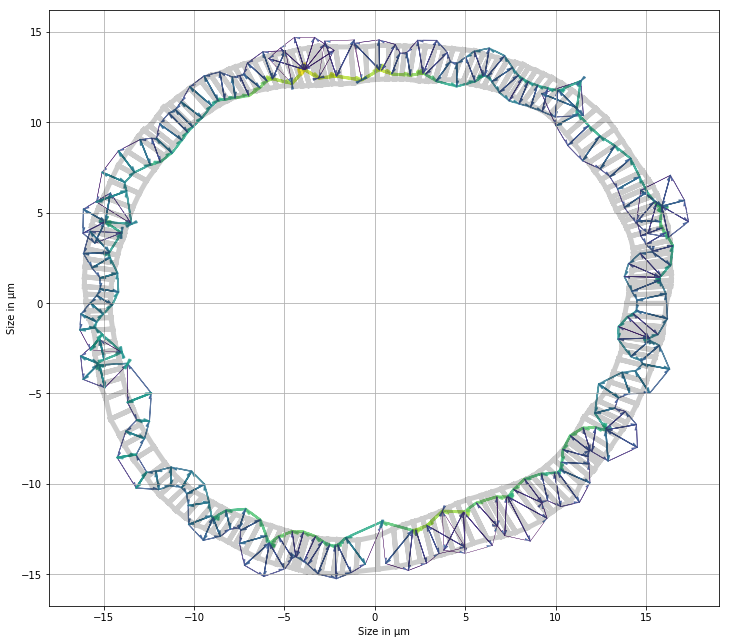

In [54]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas_copy.x[:organo.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas_copy.x[4*organo.Nf:5*organo.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas_copy.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*organo.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf]))))

Fifth try : initial point obatined with NNLS computing only tensions (pressions are discarted from the model)

Energy before optimization:  26.974732671111962
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
`xtol` termination condition is satisfied.
Function evaluations 7830, initial cost 7.9762e-03, final cost 3.8507e-03, first-order optimality 1.51e-02.
Solving time: 1781.898202
Energy after optimization:  1.4958729204164853
Tension error: [0.95185189 0.94633244 0.93959471 0.94340983 0.94315093 0.94130333
 0.93827739 0.93790372 0.93682158 0.93873331 0.94265672 0.94266905
 0.9429542  0.95184573 0.95803755 0.95983023 0.96466574 0.9754456
 0.97903945 0.97605923 0.97671837 0.98115644 0.97374518 0.96810053
 0.9716774  0.96963435 0.97049541 0.96660896 0.96650734 0.9676076
 0.97197143 0.97140853 0.97098181 0.97138671 0.97572347 0.97515586
 0.97592847 0.97888277 0.97848982 0.97069718 0.96011546 0.95294293
 0.94705109 0.94354    0.937653   0

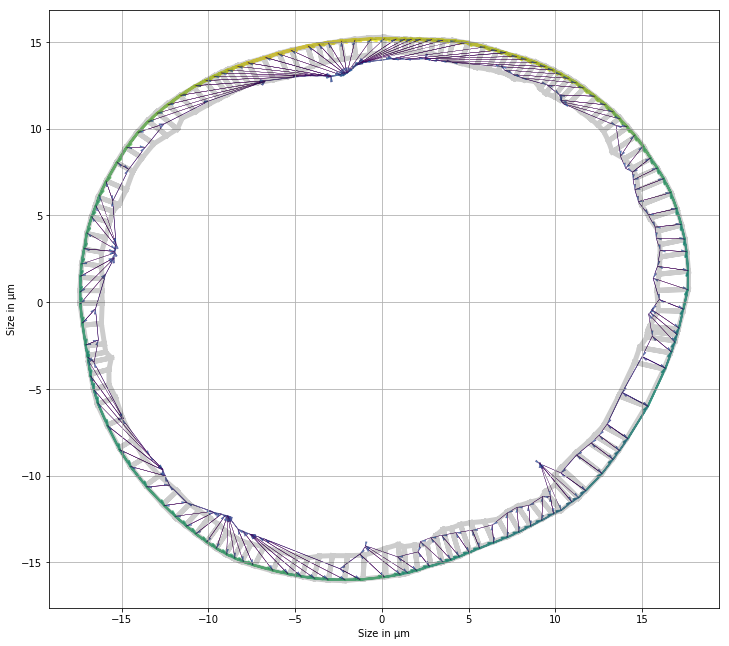

In [7]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

Fourth try : initial point obatined with the quadratic problem

Energy before optimization:  26.974732671111962
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
`xtol` termination condition is satisfied.
Function evaluations 392, initial cost 6.1358e+01, final cost 4.8313e+01, first-order optimality 6.19e+06.
Solving time: 19266.948592999997
Energy after optimization:  1.5381874608408257
Tension error: [0.97421065 0.96345586 0.95621664 0.9552855  0.96138572 0.96716513
 0.96772828 0.96374    0.95827504 0.95461498 0.95508412 0.95290652
 0.94952315 0.95128577 0.95159523 0.95261555 0.95328891 0.9611399
 0.96278205 0.94071252 0.96658762 0.96137693 0.96189297 0.9541257
 0.95469208 0.94882469 0.95228566 0.95881459 0.94353866 0.94866522
 0.9753143  0.90863679 0.95684102 0.95293862 0.96390614 0.956175
 0.96718809 0.96445459 0.97456376 0.98806145 0.94775966 0.92564061
 0.92468638 0.93484312 0.940469

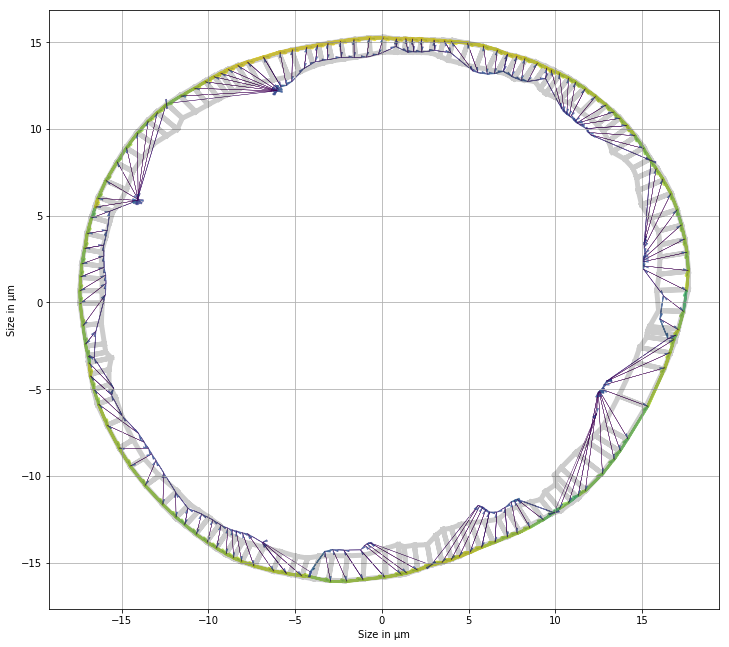

In [6]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

Third try : solve the force inference system with Moore-Penrose pseudo inverse. Small alpha.


Energy before optimization:  26.974732671111962
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
`xtol` termination condition is satisfied.
Function evaluations 1984, initial cost 2.2515e+02, final cost 9.6025e+01, first-order optimality 9.25e+06.
Solving time: 123649.985237
Energy after optimization:  -0.3109609118005637
Tension error: [0.95124118 0.93958983 0.94638587 0.81267273 1.01232571 0.97575608
 0.8004672  0.93524529 0.91969609 0.87736951 0.8572641  0.91553559
 1.010177   0.84748513 1.0012655  0.92441679 0.98524878 0.86461509
 0.97343518 0.93485096 0.99249482 0.91694999 0.89812184 1.0113707
 0.92554219 0.93225627 0.8324549  0.9788298  0.92841077 0.97343163
 0.9744234  0.79427212 0.81069443 0.95356837 0.87591968 1.00281781
 0.90493512 0.9535247  0.90368765 1.03751673 0.93411282 0.88102894
 0.93165226 0.82055853 0.908568

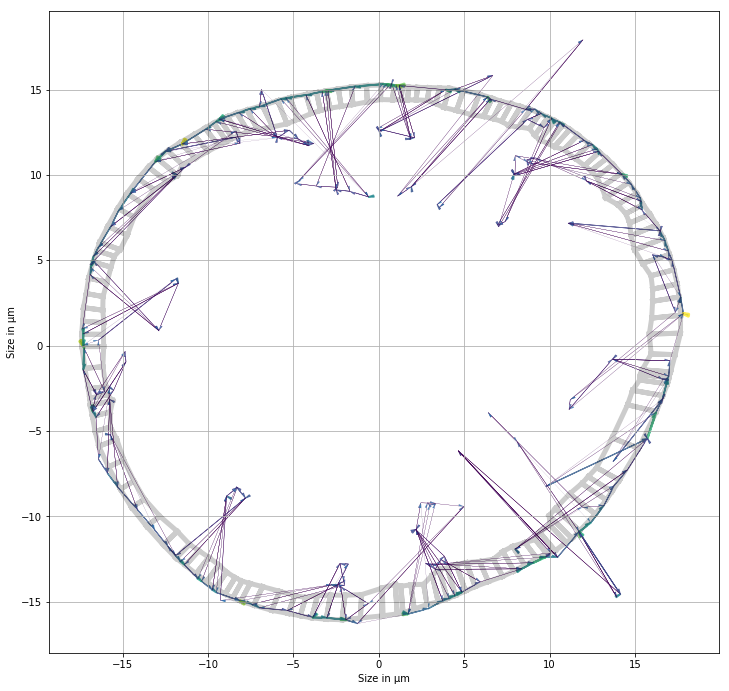

In [14]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

Second try : solve the system obtained with the homogeneous model with Moore-Penrose pseudo inverse. Small alpha.


Energy before optimization:  216.5933862947084
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
`xtol` termination condition is satisfied.
Function evaluations 1580, initial cost 2.6990e+03, final cost 2.4456e+03, first-order optimality 5.50e+07.
Solving time: 65640.566593
Energy after optimization:  3805.5322425517993
Tension error: [ 3.02276182  3.02277043  3.02277668  3.02277629  3.02276154  3.02278538
  3.02278413  3.02278893  3.02276749  3.02278443  3.02280448  3.02277384
  3.02279152  3.02278972  3.02276938  3.02278429  3.02277361  3.02279699
  3.02278762  3.02278986  3.02276964  3.02280277  3.02277346  3.02277379
  3.0227925   3.02279328  3.02279448  3.02278274  3.02278307  3.02282023
  3.02278013  3.0227779   3.0227901   3.02277446  3.02278059  3.0227794
  3.02279506  3.022782    3.02276948  3.02277822  3.0227949   3.0

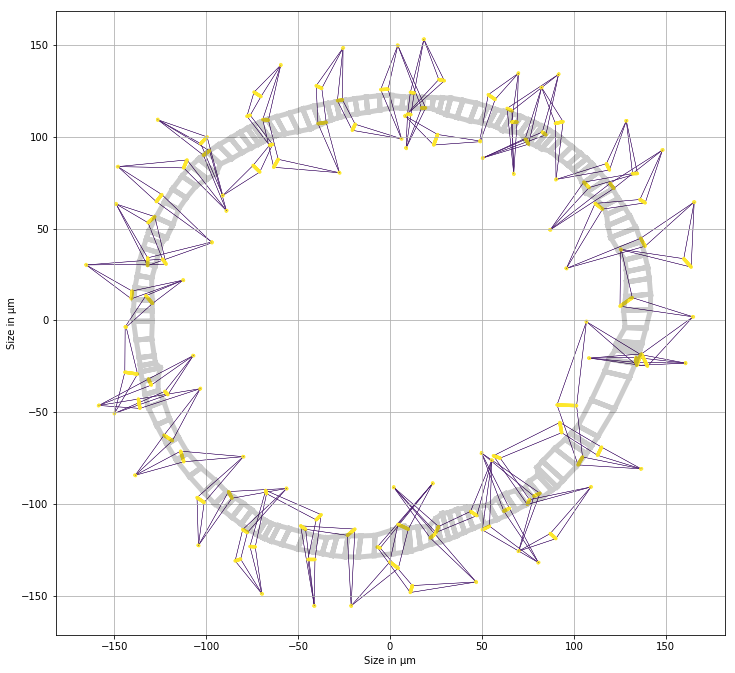

In [29]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

First try : solve the system obtained with the homogeneous model with Moore-Penrose pseudo inverse. Large alpha.


Solving time: 25905.305013
Energy after optimization:  173069.65545902174
Tension error: [ 200.13881532  200.1392852   200.13935792  200.13960175  200.13919907
  200.13803355  200.13928887  200.13825485  200.13962205  200.13996098
  200.13897848  200.13871235  200.13981547  200.13961735  200.13802922
  200.13947003  200.13914418  200.1403701   200.13965397  200.13944602
  200.1389443   200.13942178  200.13814027  200.13906622  200.13915735
  200.13880416  200.13746967  200.13945617  200.13888099  200.13875323
  200.13801211  200.13960835  200.13955018  200.13929021  200.13934588
  200.14011705  200.13983581  200.13897652  200.13881795  200.13948514
  200.13845425  200.13921186  200.13966117  200.13775847  200.13958859
  200.14057786  200.13899095  200.13841782  200.13886768  200.13900226
  200.13975761  200.13859976  200.14087218  200.13919971  200.14010327
  200.13910183  200.13925985  200.13941757  200.13959903  200.13895474
  200.13938509  200.14010269  200.13947188  200.1401081   2

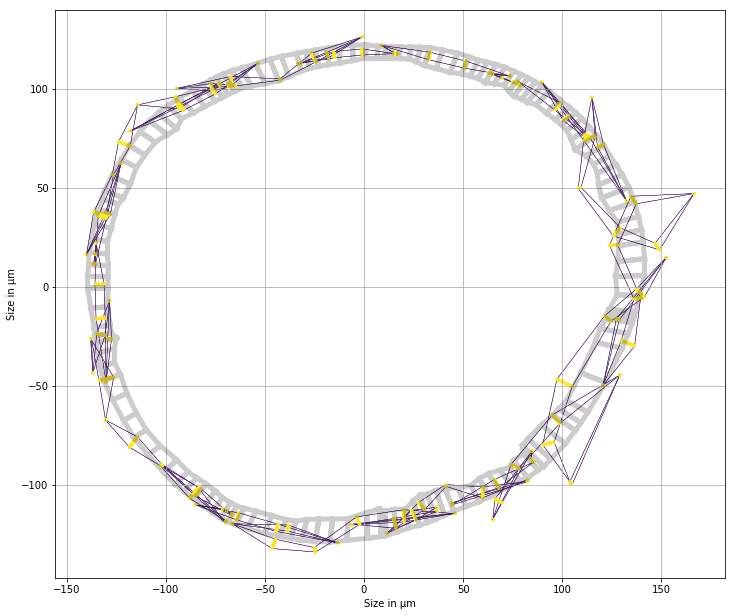

In [12]:
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl['x'])
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl['x']),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

inf 0.0


/home/fquinton/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/fquinton/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


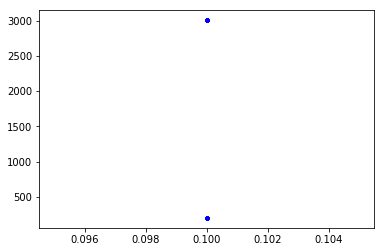

In [13]:
var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl['x']),
                     np.full(resc_lm_nr_nl['x'].shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf] ,var_tens)
print(std_err, r_value)
plt.plot(organo.edge_df.line_tension.values[:3*Nf], var_tens, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')